<a href="https://colab.research.google.com/github/edithgomezs/Natural-Language-Processing-Final-Project/blob/main/Task2_NLP_Yelp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from sklearn.utils import resample
from google.colab import files
import json
import pandas as pd
from IPython.display import HTML, display
import time
import gc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import string
import nltk 
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import Trainer, TrainingArguments

# Reading and Processing the Data set

In [ ]:
!pip install -q kaggle
from google.colab import files
import json
import pandas as pd
import gc
import matplotlib.pyplot as plt
from IPython.display import HTML, display
import time
!pip install transformers
from transformers import Trainer
from transformers import TrainingArguments
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding
!pip install datasets
from datasets import load_metric
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import re
import tensorflow as tf

# Serializing json
json_object = json.dumps({"username":"margaretearnest","key":"eea4cccb1ee7693f36add93a14642d7e"}, indent=4)

# Writing to kaggle.json
with open("kaggle.json", "w") as outfile:
    outfile.write(json_object)

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d yelp-dataset/yelp-dataset
! mkdir train
! unzip -o yelp-dataset.zip -d train
! rm yelp-dataset.zip

In [ ]:
max = 6290515
def progress(value):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

In [ ]:
# Read in and process data
chunk = 100000
chunks = pd.read_json('train/yelp_academic_dataset_review.json', lines=True, chunksize=chunk)
df = pd.DataFrame()

out = display(progress(0), display_id=True)
i = chunk

for c in chunks:
    df = pd.concat([df, c])
    out.update(progress(i))
    i += chunk

In [ ]:
def findCorrelations(column, colTitle):
  print("Correlation between " + colTitle + " and Funny scores", column.corr(df['funny']))
  print("Correlation between " + colTitle + " and Useful scores", column.corr(df['useful']))
  print("Correlation between " + colTitle + " and Cool scores", column.corr(df['cool']), "\n")

def getAverageWordLength(n):
  words = n.split()
  return sum(len(word) for word in words) / len(words)

In [ ]:
# Need a dataframe of a sample size with text, star rating, user stats
df.drop(columns=['business_id', 'date'], inplace=True)
df = df.sample(frac=0.2)
gc.collect()

0

In [ ]:
print(df["funny"].max())
print(df["funny"].mean())
print(df["useful"].max())
print(df["useful"].mean())
print(df["cool"].max())
print(df["cool"].mean())

375
0.3255913926194659
1182
1.182273099217771
400
0.4955559720068438


In [ ]:
chunk = 100000
max = 1987896
chunks = pd.read_json('train/yelp_academic_dataset_user.json', lines=True, chunksize=chunk)
users = pd.DataFrame()

out = display(progress(0), display_id=True)
i = chunk

for c in chunks:
    users = pd.concat([users, c])
    out.update(progress(i))
    i += chunk

In [ ]:
# Renaming columns to prevent clash between useful, funny, cool columns in the review and user datasets
df.rename(columns={"useful": "review_useful", "funny": "review_funny", "cool": "review_cool"}, inplace=True)
data = pd.merge(df, users[["user_id", "useful", "funny", "cool"]], on=["user_id"])
userScoreSums = data[["useful", "funny", "cool"]].sum(axis=1)
data["user_useful"] = (data["useful"] / userScoreSums).fillna(1/3)
data["user_funny"] = (data["funny"] / userScoreSums).fillna(1/3)
data["user_cool"] = (data["cool"] / userScoreSums).fillna(1/3)
data.drop(columns=['useful', 'funny', 'cool'], inplace=True)
data.rename(columns={"review_useful": "useful", "review_funny": "funny", "review_cool": "cool"}, inplace=True)
data.drop(columns=['user_id'], inplace=True)

In [ ]:
del chunks
del df
del users
gc.collect()

87

In [ ]:
# double check after merge
print(data["funny"].max())
print(data["funny"].mean())
print(data["useful"].max())
print(data["useful"].mean())
print(data["cool"].max())
print(data["cool"].mean())

375
0.32559442020023704
1182
1.182284092835485
400
0.49556058003938364


In [ ]:
data.tail(10)

,review_id,stars,useful,funny,cool,text,user_useful,user_funny,user_cool
1398033,4ZCXEtTf3TFOnP3m1HGyPQ,5,1,0,0,Everyone was friendly and welcoming. There was...,0.625000,0.125000,0.250000
1398034,L6OuTqrdiLlMqvLFyWayDg,5,0,0,0,April and John have been with us for 2 purchas...,0.500000,0.000000,0.500000
1398035,ZWGBkDaS81RZz-SB0_NFQw,3,0,0,0,2/22/2021 - Huge fan of Mad Mex and haven't be...,0.666667,0.000000,0.333333
1398036,4DGA9HH18s_ifFO0zeR_SA,1,2,0,0,Do not take your dogs to the salon. I unfortun...,0.714286,0.000000,0.285714
1398037,FRxtN_8JSKdiTU0Eks5NBw,1,0,0,0,I experienced a horrible experience and custom...,0.400000,0.400000,0.200000
1398038,mQNNgVLdcv0pSjo9xpx1ng,5,0,0,0,"Best tacos ,burritos and tortas in town!!!\nRe...",0.333333,0.333333,0.333333
1398039,MyrCqiVNZIMdmlwKl45ymg,2,0,0,0,The Mrs. and I tried the updated Diamond Diner...,0.333333,0.333333,0.333333
1398040,dyzFL_d6f5KnuOqdWl-rBA,5,0,0,0,Not only is this the best Mexican in East Nash...,0.800000,0.100000,0.100000
1398041,BotWI74kUPrGqczTnddejw,5,0,0,0,Loved it. Amazing burgers. A little loud insid...,0.600000,0.000000,0.400000
1398042,XNvfChtLjzCyDakIfY07TQ,1,0,0,0,TLDR: Owner flipping off my wife and charging ...,0.333333,0.333333,0.333333


In [ ]:
data.to_csv(r'/content/drive/MyDrive/yelp_data_sample.csv') 

In [ ]:
del data 
gc.collect()

0

## Reading the Dataset

In [ ]:
# Conect notebook to google drive folders
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv(r'/content/drive/MyDrive/yelp_data_sample.csv')
df.head(10)

,Unnamed: 0,review_id,stars,useful,funny,cool,text,user_useful,user_funny,user_cool
0,0,BFaW6f0VQ1BHCF0JCtDkyg,4,5,3,2,I lived here for two years and really liked it...,0.628049,0.158537,0.213415
1,1,5cjA-ZZDdZDqQgzhIRLyCw,4,0,0,0,We had a groupon/living social (some deal!) fo...,0.628049,0.158537,0.213415
2,2,4WuqRDC--to0vSiFhSYwXQ,4,1,0,2,I've had lunch many times and its a great deal...,0.628049,0.158537,0.213415
3,3,B5xq-_eZK7wAmzqwRTSGIw,3,1,1,0,We arranged for a rather large group at Jolly'...,0.628049,0.158537,0.213415
4,4,SF0TjRXMZG0Ky4NsY887Aw,4,0,0,0,5 stars for the chocolate pizza (with bananas ...,0.628049,0.158537,0.213415
5,5,KhmqvdkCSz-I--GqE9y8vA,5,1,0,0,"It's best to go on off days/times, but this pl...",0.628049,0.158537,0.213415
6,6,hoWQGSgMYkMsrN-ClgiSEg,5,0,0,0,I love ESP. \n\nI went to their Halloween eve...,0.628049,0.158537,0.213415
7,7,CJZwchkHlrkXQa9wJTOQpQ,4,2,0,2,I've been here twice now and have had a facial...,0.628049,0.158537,0.213415
8,8,lPHydYGuTRD5ncmGL6q01g,1,0,0,0,I will not be returning to Minar in the future...,0.628049,0.158537,0.213415
9,9,J9KICzF17FLwFWt2AOI57A,4,0,0,0,Its really hard to find good produce in Ritten...,0.628049,0.158537,0.213415


0

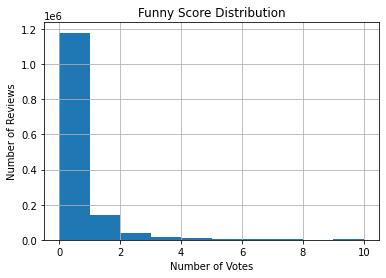

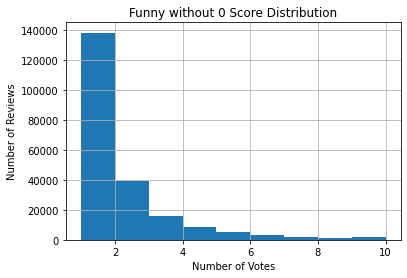

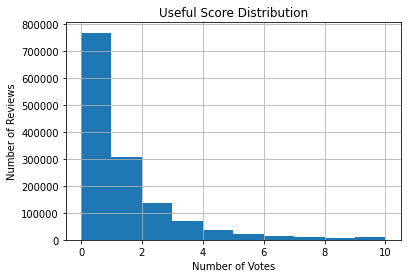

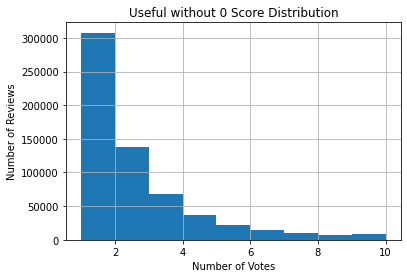

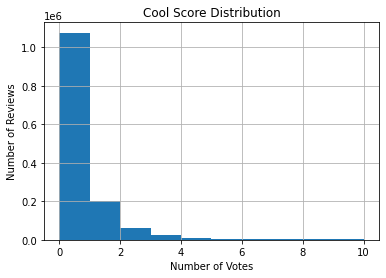

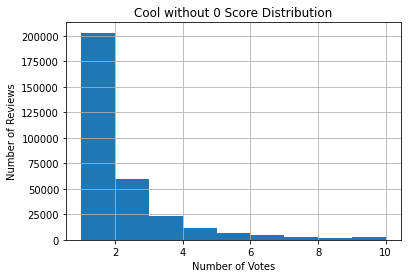

In [ ]:
def setHistLabels(title):
  plt.title(title + ' Score Distribution')
  plt.xlabel('Number of Votes')
  plt.ylabel('Number of Reviews')

# Review scores distribution of U,F,C
hist = df.hist(bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], column=["funny"])
setHistLabels("Funny")
hist = df.hist(bins=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], column=["funny"])
setHistLabels("Funny without 0")
hist1 = df.hist(bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], column=["useful"])
setHistLabels("Useful")
hist1 = df.hist(bins=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], column=["useful"])
setHistLabels("Useful without 0")
hist2 = df.hist(bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], column=["cool"])
setHistLabels("Cool")
hist2 = df.hist(bins=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], column=["cool"])
setHistLabels("Cool without 0")

del hist
del hist1
del hist2
gc.collect()

In [ ]:
# All 3 features (Useful, Funny, Cool) has high concentration of 0 score (no rating)
# To adapt this unbalance distribution while maintaining the majority of the dataset, 
#  1 will be chosen as the threshold value for all 3 features.
# 1/0 indicates success/failure for passing the threshold
df['useful_pass'] = np.where(df['useful']>=1, 1, 0)
df['funny_pass'] = np.where(df['funny']>=1, 1, 0)
df['cool_pass'] = np.where(df['cool']>=1, 1, 0)

In [ ]:
df.tail(10)

,Unnamed: 0,review_id,stars,useful,funny,cool,text,user_useful,user_funny,user_cool,useful_pass,funny_pass,cool_pass
1398033,1398033,4ZCXEtTf3TFOnP3m1HGyPQ,5,1,0,0,Everyone was friendly and welcoming. There was...,0.625000,0.125000,0.250000,1,0,0
1398034,1398034,L6OuTqrdiLlMqvLFyWayDg,5,0,0,0,April and John have been with us for 2 purchas...,0.500000,0.000000,0.500000,0,0,0
1398035,1398035,ZWGBkDaS81RZz-SB0_NFQw,3,0,0,0,2/22/2021 - Huge fan of Mad Mex and haven't be...,0.666667,0.000000,0.333333,0,0,0
1398036,1398036,4DGA9HH18s_ifFO0zeR_SA,1,2,0,0,Do not take your dogs to the salon. I unfortun...,0.714286,0.000000,0.285714,1,0,0
1398037,1398037,FRxtN_8JSKdiTU0Eks5NBw,1,0,0,0,I experienced a horrible experience and custom...,0.400000,0.400000,0.200000,0,0,0
1398038,1398038,mQNNgVLdcv0pSjo9xpx1ng,5,0,0,0,"Best tacos ,burritos and tortas in town!!!\nRe...",0.333333,0.333333,0.333333,0,0,0
1398039,1398039,MyrCqiVNZIMdmlwKl45ymg,2,0,0,0,The Mrs. and I tried the updated Diamond Diner...,0.333333,0.333333,0.333333,0,0,0
1398040,1398040,dyzFL_d6f5KnuOqdWl-rBA,5,0,0,0,Not only is this the best Mexican in East Nash...,0.800000,0.100000,0.100000,0,0,0
1398041,1398041,BotWI74kUPrGqczTnddejw,5,0,0,0,Loved it. Amazing burgers. A little loud insid...,0.600000,0.000000,0.400000,0,0,0
1398042,1398042,XNvfChtLjzCyDakIfY07TQ,1,0,0,0,TLDR: Owner flipping off my wife and charging ...,0.333333,0.333333,0.333333,0,0,0


In [ ]:
# Double check sentiments correcta after import from Drive
print(df["funny"].max())
print(df["funny"].mean())
print(df["useful"].max())
print(df["useful"].mean())
print(df["cool"].max())
print(df["cool"].mean())

Seeing the sentiment distribution

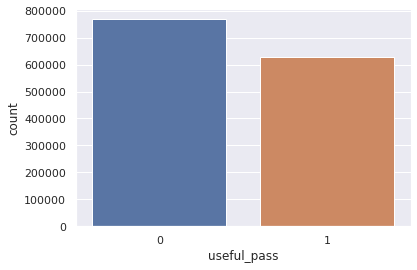

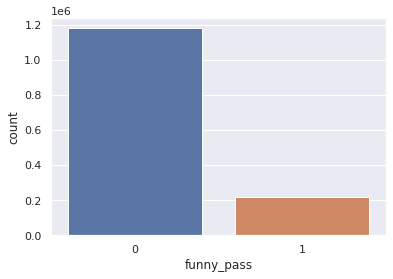

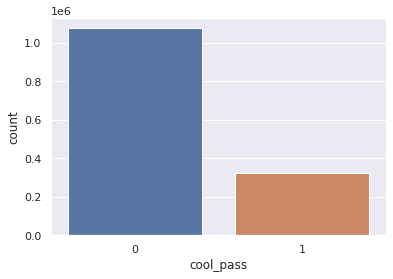

In [ ]:
sns.set(style='darkgrid')
ax = sns.countplot(x='useful_pass', data=df)
plt.show()

sns.set(style='darkgrid')
ax = sns.countplot(x='funny_pass', data=df)
plt.show()

sns.set(style='darkgrid')
ax = sns.countplot(x='cool_pass', data=df)
plt.show()

####Resampling one label cannot solve imbalance of others, so we move on with this imbalanced distribution of dataset.

# Task 2 - Can we predict whether a review hits thresholds for sentiments? (boolean outputs for Useful, Funny, and Cool)

## Approach 1: Multi-label Text Classification Model with Single Output Layer

In [ ]:
def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)
    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [ ]:
df['preprocessed_text'] = df['text'].apply(preprocess_text)
df.head(10)

,Unnamed: 0,review_id,stars,useful,funny,cool,text,user_useful,user_funny,user_cool,useful_pass,funny_pass,cool_pass,preprocessed_text
0,0,BFaW6f0VQ1BHCF0JCtDkyg,4,5,3,2,I lived here for two years and really liked it...,0.628049,0.158537,0.213415,1,1,1,I lived here for two years and really liked it...
1,1,5cjA-ZZDdZDqQgzhIRLyCw,4,0,0,0,We had a groupon/living social (some deal!) fo...,0.628049,0.158537,0.213415,0,0,0,We had groupon living social some deal for Max...
2,2,4WuqRDC--to0vSiFhSYwXQ,4,1,0,2,I've had lunch many times and its a great deal...,0.628049,0.158537,0.213415,1,0,1,I ve had lunch many times and its great deal i...
3,3,B5xq-_eZK7wAmzqwRTSGIw,3,1,1,0,We arranged for a rather large group at Jolly'...,0.628049,0.158537,0.213415,1,1,0,We arranged for rather large group at Jolly an...
4,4,SF0TjRXMZG0Ky4NsY887Aw,4,0,0,0,5 stars for the chocolate pizza (with bananas ...,0.628049,0.158537,0.213415,0,0,0,stars for the chocolate pizza with bananas an...
5,5,KhmqvdkCSz-I--GqE9y8vA,5,1,0,0,"It's best to go on off days/times, but this pl...",0.628049,0.158537,0.213415,1,0,0,It best to go on off days times but this place...
6,6,hoWQGSgMYkMsrN-ClgiSEg,5,0,0,0,I love ESP. \n\nI went to their Halloween eve...,0.628049,0.158537,0.213415,0,0,0,I love ESP went to their Halloween event and l...
7,7,CJZwchkHlrkXQa9wJTOQpQ,4,2,0,2,I've been here twice now and have had a facial...,0.628049,0.158537,0.213415,1,0,1,I ve been here twice now and have had facial a...
8,8,lPHydYGuTRD5ncmGL6q01g,1,0,0,0,I will not be returning to Minar in the future...,0.628049,0.158537,0.213415,0,0,0,I will not be returning to Minar in the future...
9,9,J9KICzF17FLwFWt2AOI57A,4,0,0,0,Its really hard to find good produce in Ritten...,0.628049,0.158537,0.213415,0,0,0,Its really hard to find good produce in Ritten...


In [ ]:
reviews = []
sentences = list(df['preprocessed_text'])
for sen in sentences:
    reviews.append(preprocess_text(sen))

yelp_labels = df[["useful_pass", "funny_pass", "cool_pass"]]
yelp_labels.head()
gc.collect()

22649

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(reviews, yelp_labels.values, test_size=0.20, random_state=42)

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

gc.collect()

0

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2022-12-15 03:03:28--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-12-15 03:03:28--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-12-15 03:03:29--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

gc.collect()

0

In [ ]:
from keras.layers import Flatten, LSTM, Input
from keras.models import Model
from keras.layers.core import Activation, Dropout, Dense
from tensorflow.keras.layers import Embedding

deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(deep_inputs)
LSTM_Layer_1 = LSTM(128)(embedding_layer)
dense_layer_1 = Dense(3, activation='sigmoid')(LSTM_Layer_1)
model = Model(inputs=deep_inputs, outputs=dense_layer_1)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding (Embedding)       (None, 200, 100)          22152700  
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                                 
Total params: 22,270,335
Trainable params: 117,635
Non-trainable params: 22,152,700
_________________________________________________________________
None


In [ ]:
history = model.fit(X_train, y_train, batch_size=128, epochs=5, verbose=1, validation_split=0.2)

Epoch 1/5
6991/6991 [==============================] - 3143s 449ms/step - loss: 0.5170 - acc: 0.9431 - val_loss: 0.5080 - val_acc: 0.9427
Epoch 2/5
6991/6991 [==============================] - 3178s 455ms/step - loss: 0.5053 - acc: 0.9432 - val_loss: 0.5038 - val_acc: 0.9427
Epoch 3/5
6991/6991 [==============================] - 3254s 465ms/step - loss: 0.5017 - acc: 0.9431 - val_loss: 0.5014 - val_acc: 0.9427
Epoch 4/5
6991/6991 [==============================] - 3244s 464ms/step - loss: 0.4993 - acc: 0.9430 - val_loss: 0.5015 - val_acc: 0.9425
Epoch 5/5
6991/6991 [==============================] - 3187s 456ms/step - loss: 0.4972 - acc: 0.9428 - val_loss: 0.5013 - val_acc: 0.9424


In [ ]:
score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

8738/8738 [==============================] - 643s 74ms/step - loss: 0.5009 - acc: 0.9424
Test Score: 0.5009253621101379
Test Accuracy: 0.9423945546150208


# Approach 2: Multi-class Text Classification with Fine tune BERT

In [ ]:
# Convert U,F,C sentiments into classes
# 0 - None         passed
# 1 - Only Useful  passed
# 2 - Only Funny   passed
# 3 - Only Cool    passed
# 4 - Useful&Funny passed
# 5 - Useful&Cool  passed
# 6 - Funny&Cool   passed
# 7 - All          passed

conditions = [
    (df['useful_pass'] == 0) & (df['funny_pass'] == 0) & (df['cool_pass'] == 0),
    (df['useful_pass'] == 1) & (df['funny_pass'] == 0) & (df['cool_pass'] == 0),
    (df['useful_pass'] == 0) & (df['funny_pass'] == 1) & (df['cool_pass'] == 0),
    (df['useful_pass'] == 0) & (df['funny_pass'] == 0) & (df['cool_pass'] == 1),
    (df['useful_pass'] == 1) & (df['funny_pass'] == 1) & (df['cool_pass'] == 0),
    (df['useful_pass'] == 1) & (df['funny_pass'] == 0) & (df['cool_pass'] == 1),
    (df['useful_pass'] == 0) & (df['funny_pass'] == 1) & (df['cool_pass'] == 1),
    (df['useful_pass'] == 1) & (df['funny_pass'] == 1) & (df['cool_pass'] == 1)
]
values = ['0', '1', '2', '3', '4', '5', '6', '7']

df['Label'] = np.select(conditions, values)
df.head()

,Unnamed: 0,review_id,stars,useful,funny,cool,text,user_useful,user_funny,user_cool,useful_pass,funny_pass,cool_pass,Label
0,0,BFaW6f0VQ1BHCF0JCtDkyg,4,5,3,2,I lived here for two years and really liked it...,0.628049,0.158537,0.213415,1,1,1,7
1,1,5cjA-ZZDdZDqQgzhIRLyCw,4,0,0,0,We had a groupon/living social (some deal!) fo...,0.628049,0.158537,0.213415,0,0,0,0
2,2,4WuqRDC--to0vSiFhSYwXQ,4,1,0,2,I've had lunch many times and its a great deal...,0.628049,0.158537,0.213415,1,0,1,5
3,3,B5xq-_eZK7wAmzqwRTSGIw,3,1,1,0,We arranged for a rather large group at Jolly'...,0.628049,0.158537,0.213415,1,1,0,4
4,4,SF0TjRXMZG0Ky4NsY887Aw,4,0,0,0,5 stars for the chocolate pizza (with bananas ...,0.628049,0.158537,0.213415,0,0,0,0


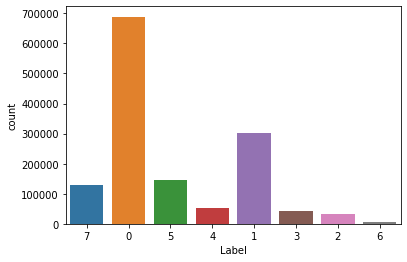

In [ ]:
# Class distribution 
sns.countplot(x='Label', data=df)
plt.show()

In [ ]:
# Undersampling to balance distribution 
downsampling_size = len(df[df['Label'] == '6'])
none_data = df[df['Label'] == '0']
u_data = df[df['Label'] == '1']
f_data = df[df['Label'] == '2']
c_data = df[df['Label'] == '3']
uf_data = df[df['Label'] == '4']
uc_data = df[df['Label'] == '5']
fc_data = df[df['Label'] == '6']
all_data = df[df['Label'] == '7']

none_down = resample(none_data, replace=True, n_samples=downsampling_size, random_state=42)
u_down = resample(u_data, replace=True, n_samples=downsampling_size, random_state=42)
f_down = resample(f_data, replace=True, n_samples=downsampling_size, random_state=42)
c_down = resample(c_data, replace=True, n_samples=downsampling_size, random_state=42)
uf_down = resample(uf_data, replace=True, n_samples=downsampling_size, random_state=42)
uc_down = resample(uc_data, replace=True, n_samples=downsampling_size, random_state=42)
all_down = resample(all_data, replace=True, n_samples=downsampling_size, random_state=42)
gc.collect()

47

In [ ]:
data_downsampled = pd.concat([none_down, u_down, f_down, c_down, uf_down, uc_down, fc_data, all_down])

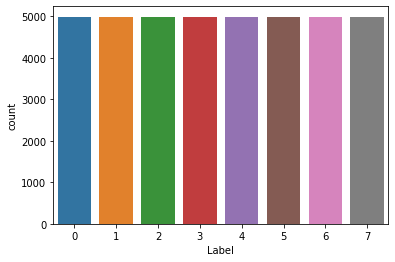

In [ ]:
#4988 each --> 39904 instances total
sns.countplot(x='Label', data=data_downsampled)
plt.show()

In [ ]:
data_downsampled['Label'] = data_downsampled['Label'].replace(['0','1','2','3','4','5','6','7'],[0,1,2,3,4,5,6,7]) 
gc.collect()

In [ ]:
# Truncate the input text data to the maximum sequence length of the BERT model
# Tokenize the text data and create input features for BERT
MAX_LEN = 512
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', num_labels=8, do_lower_case = True)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
y = data_downsampled['Label'].values
dsm = data_downsampled.copy()
dsm.drop(['Label'], axis=1, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(dsm, y, test_size=0.2, stratify=y)

train_text = X_train['preprocessed_text'].values.tolist()
valid_text = X_test['preprocessed_text'].values.tolist()
train_label = y_train
valid_label = y_test

In [ ]:
# tokenize the dataset, truncate when passed `max_length`, and pad with 0's when less than `max_length`
train_encodings = tokenizer(train_text, truncation=True, padding=True, max_length=MAX_LEN)
valid_encodings = tokenizer(valid_text, truncation=True, padding=True, max_length=MAX_LEN)

In [ ]:
class CreationofTorchDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        return item

    def __len__(self):
        return len(self.labels)

# convert our tokenized data into a torch Dataset
train_dataset = CreationofTorchDataset(train_encodings, train_label)
valid_dataset = CreationofTorchDataset(valid_encodings, valid_label)

In [ ]:
# load the model and pass to CUDA
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=8).to("cuda")

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  acc = accuracy_score(labels, preds)
  recall = recall_score(labels, preds, average='macro')
  precision = precision_score(labels, preds, average='macro')
  f1 = f1_score(labels, preds, average='macro')
  return {
      'accuracy': acc,
      'precision': precision,
      'recall': recall,
      'f1': f1
}

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=2,              # total number of training epochs
    per_device_train_batch_size=8,  # batch size per device during training
    per_device_eval_batch_size=20,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    load_best_model_at_end=True,     # load the best model when finished training (default metric is loss)
    # but you can specify `metric_for_best_model` argument to change to accuracy or other metric
    logging_steps=1000,              
    save_steps=50000,
    evaluation_strategy="steps", 
)    

In [ ]:
trainer = Trainer(
    model=model,                         # the instantiated Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=valid_dataset,          # evaluation dataset
    compute_metrics=compute_metrics,     # the callback that computes metrics of interest
)

In [ ]:
trainer.train()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 31923
  Num Epochs = 2
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 7982
  Number of trainable parameters = 109488392


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1000,2.017300,1.974725,0.224157,0.273984,0.224129,0.142788
2000,1.967400,1.950250,0.233555,0.237171,0.233519,0.212186
3000,1.961300,1.953870,0.228292,0.203260,0.228255,0.172884
4000,1.947500,1.916331,0.247588,0.262063,0.247571,0.235469
5000,1.857400,1.930597,0.254229,0.256488,0.254203,0.236768
6000,1.828500,1.930297,0.247839,0.248498,0.247816,0.237312
7000,1.826900,1.919809,0.257862,0.258027,0.257836,0.252868


***** Running Evaluation *****
  Num examples = 7981
  Batch size = 20
***** Running Evaluation *****
  Num examples = 7981
  Batch size = 20
***** Running Evaluation *****
  Num examples = 7981
  Batch size = 20
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
***** Running Evaluation *****
  Num examples = 7981
  Batch size = 20
***** Running Evaluation *****
  Num examples = 7981
  Batch size = 20
***** Running Evaluation *****
  Num examples = 7981
  Batch size = 20
***** Running Evaluation *****
  Num examples = 7981
  Batch size = 20


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=7982, training_loss=1.9015344033352386, metrics={'train_runtime': 7936.0397, 'train_samples_per_second': 8.045, 'train_steps_per_second': 1.006, 'total_flos': 1.6799493406998528e+16, 'train_loss': 1.9015344033352386, 'epoch': 2.0})

In [ ]:
# evaluate the current model after training

trainer.evaluate()

***** Running Evaluation *****
  Num examples = 7981
  Batch size = 20


{'eval_loss': 1.9185236692428589,
 'eval_accuracy': 0.25961658939982457,
 'eval_precision': 0.25660985558714455,
 'eval_recall': 0.25959152507623073,
 'eval_f1': 0.2540906395382118,
 'eval_runtime': 262.868,
 'eval_samples_per_second': 30.361,
 'eval_steps_per_second': 1.522,
 'epoch': 2.0}